# ![](https://img.shields.io/badge/vision-2f5ada) Train `UNet` segmenter



In this example, a `UNet` architecture is used to segment Oxford pets datasets.

This example features `serket.image` for image augmentation.


## Imports


In [1]:
!pip install git+https://github.com/ASEM000/serket --quiet
!pip install optax --quiet
!pip install ml_collections --quiet

In [2]:
import serket as sk
import jax
import functools as ft
import jax.numpy as jnp
import jax.random as jr
from math import log2
from typing_extensions import Annotated
import optax
import tensorflow_datasets as tfds
import tensorflow as tf

tf.config.set_visible_devices([], device_type="GPU")
import matplotlib.pyplot as plt
from ml_collections import ConfigDict
from typing import Generic, TypeVar
from tqdm.notebook import tqdm

T = TypeVar("T")


class Batched(Generic[T]): ...


CHWArray = Annotated[jax.Array, "CHW"]

In [3]:
config = ConfigDict()
# training
config.train = ConfigDict()
config.train.batch_size = 32
config.train.epochs = 100
config.train.seed = 0
config.train.plot_every = 10
# optimizer
config.optim = ConfigDict()
config.optim.lr = 1e-3
config.optim.beta1 = 0.9
config.optim.beta2 = 0.999
# augmentations
config.augmentation = ConfigDict()
config.augmentation.vflip_rate = 0.5
config.augmentation.hflip_rate = 0.5
config.augmentation.rotate_range = (-15, 15)
config.augmentation.vshear_range = (-15, 15)
config.augmentation.hshear_range = (-15, 15)

## Data


### Load data


In [4]:
(train_ds, test_ds) = tfds.load(name="oxford_iiit_pet", split=["train", "test"])


def preprocess_data(dataset):
    image = tf.image.resize(dataset["image"], (128, 128))
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.transpose(image, [2, 0, 1])
    mask = tf.image.resize(dataset["segmentation_mask"], (128, 128)) - 1
    mask = tf.cast(mask, tf.int32)
    mask = tf.transpose(mask, [2, 0, 1])
    return image, mask


train_ds = train_ds.map(preprocess_data).shuffle(1000).batch(config.train.batch_size)
train_ds = tfds.as_numpy(train_ds)
test_ds = test_ds.map(preprocess_data)
test_ds = tfds.as_numpy(test_ds)

### Visualize sample data


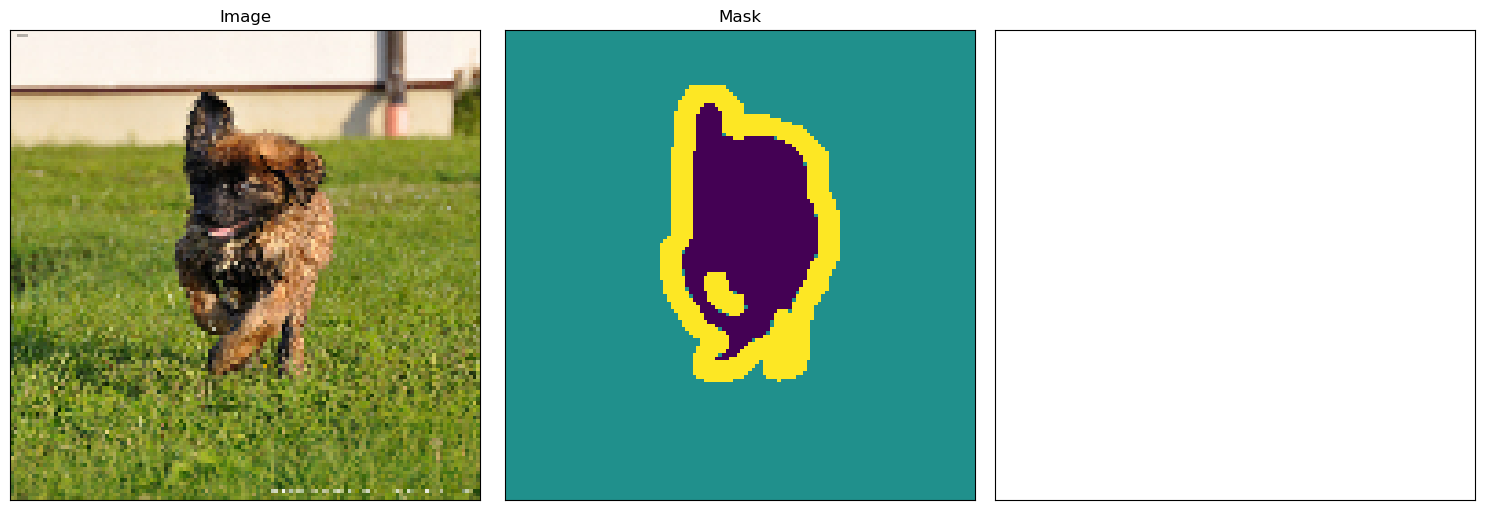

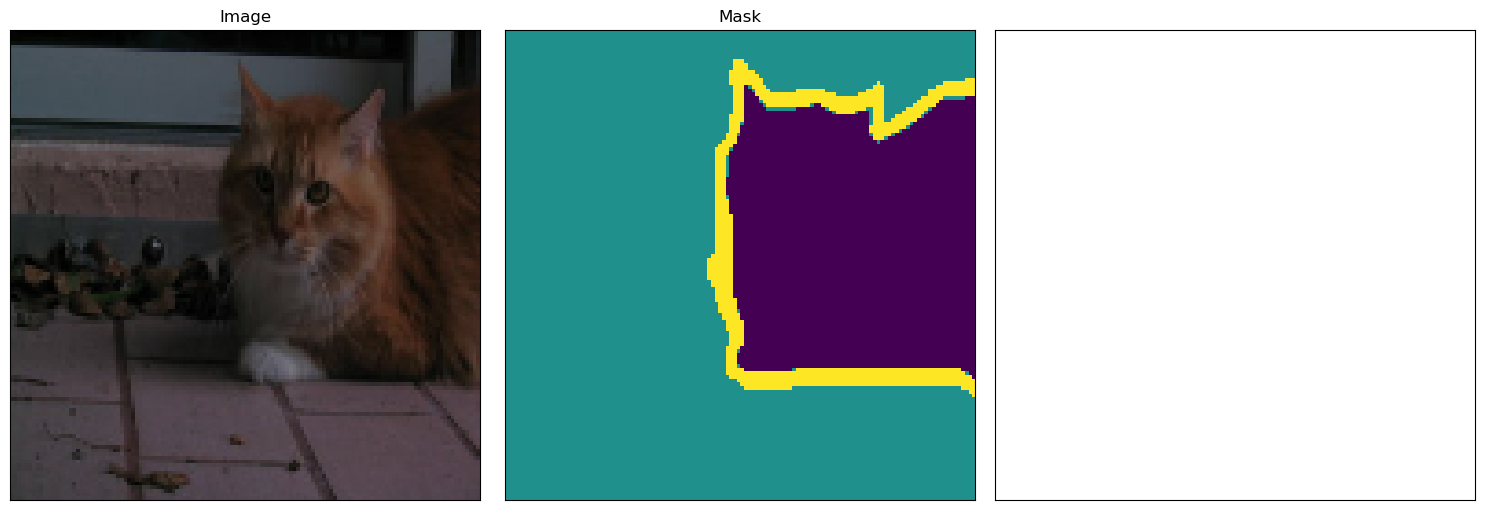

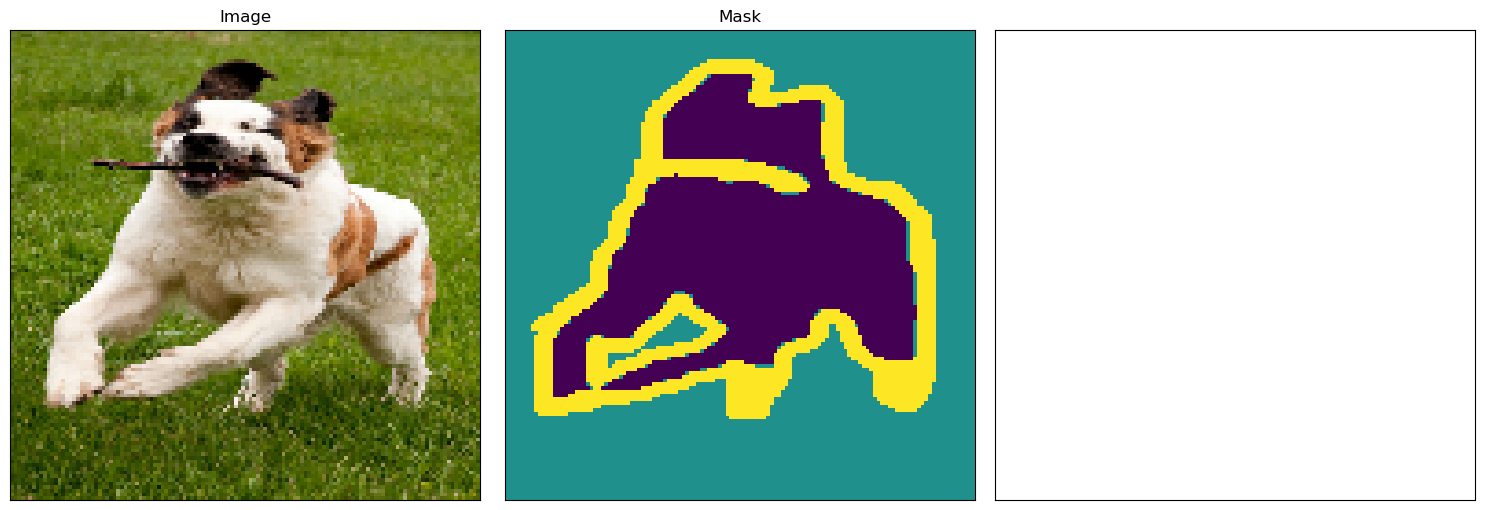

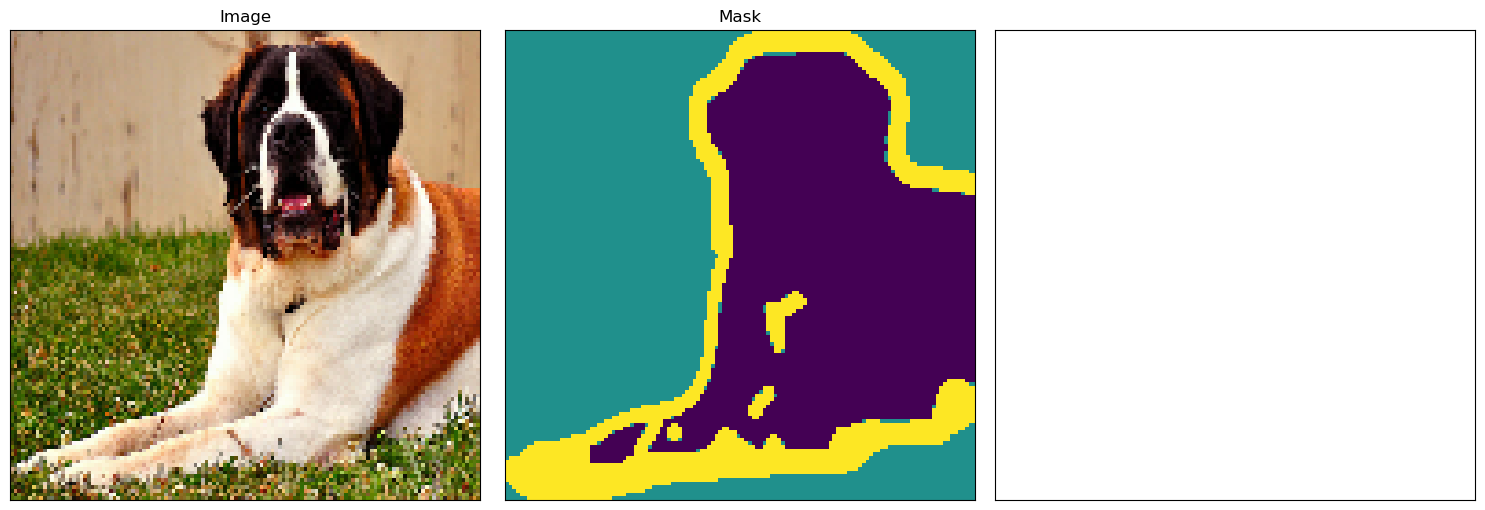

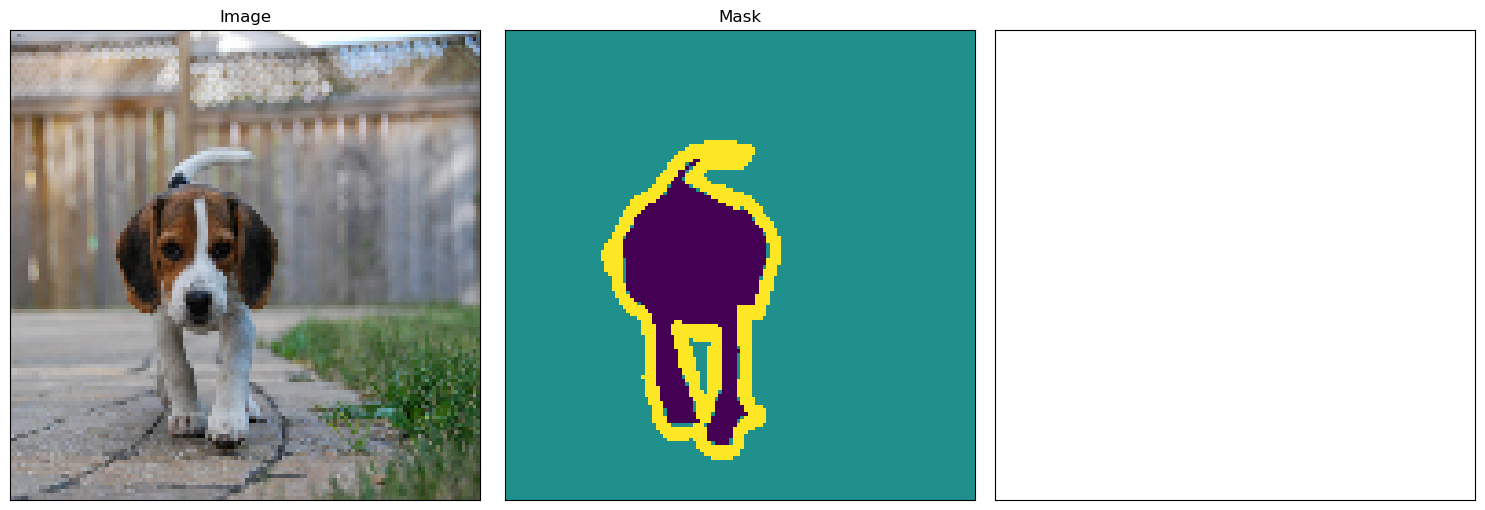

In [5]:
# check a sample
def plot_sample(image: CHWArray, mask: CHWArray, logits: CHWArray = None):
    image = image.transpose(1, 2, 0)
    mask = mask.transpose(1, 2, 0)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(image)
    ax2.imshow(mask)
    ax1.set_title("Image")
    ax2.set_title("Mask")
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3.set_xticks([])
    ax3.set_yticks([])

    if logits is not None:
        logits = logits.transpose(1, 2, 0)  # [C,H,W] -> [H,W,C]
        logits = jax.nn.softmax(logits.reshape(-1, 3), axis=-1)  # [H*W, C]
        logits = jnp.argmax(logits, axis=-1).reshape(mask.shape)
        ax3.imshow(logits)
        ax3.set_title("Prediction")
    plt.tight_layout()
    plt.show()


for _, (image, mask) in zip(range(5), test_ds):
    plot_sample(image, mask)

### Augment data


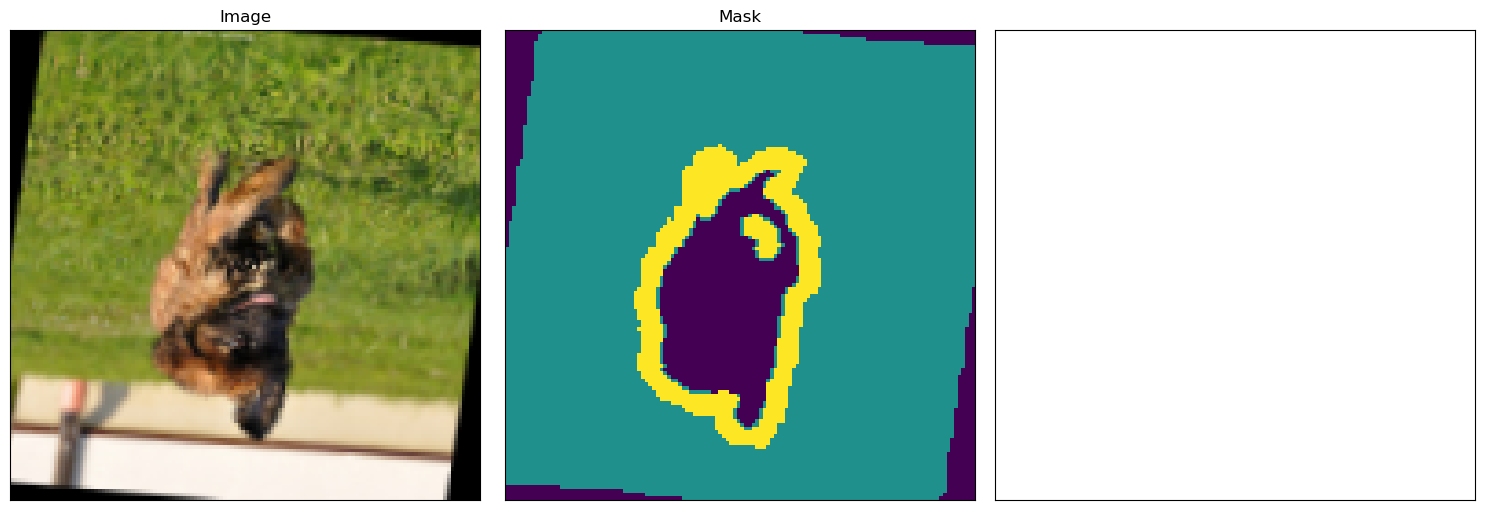

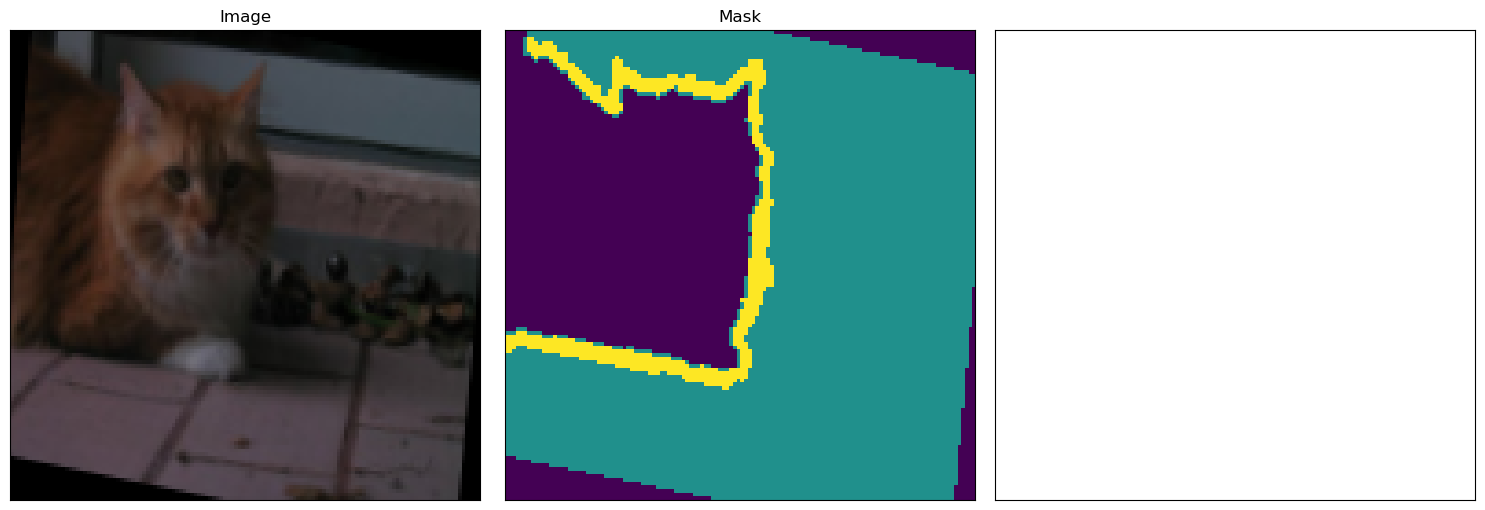

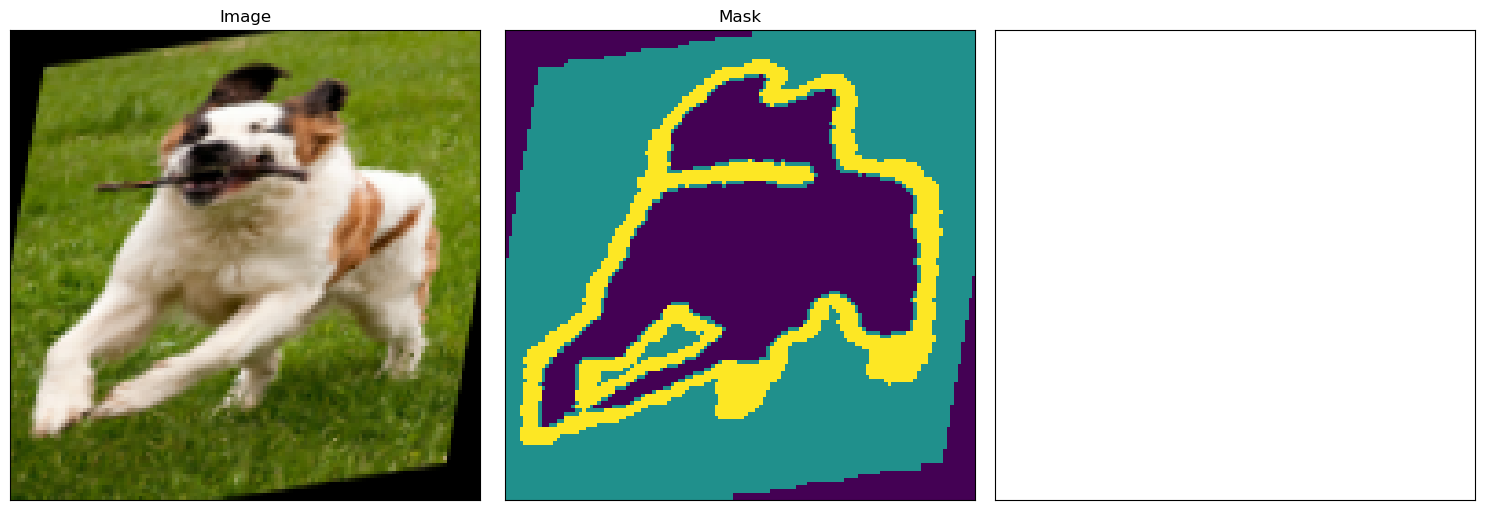

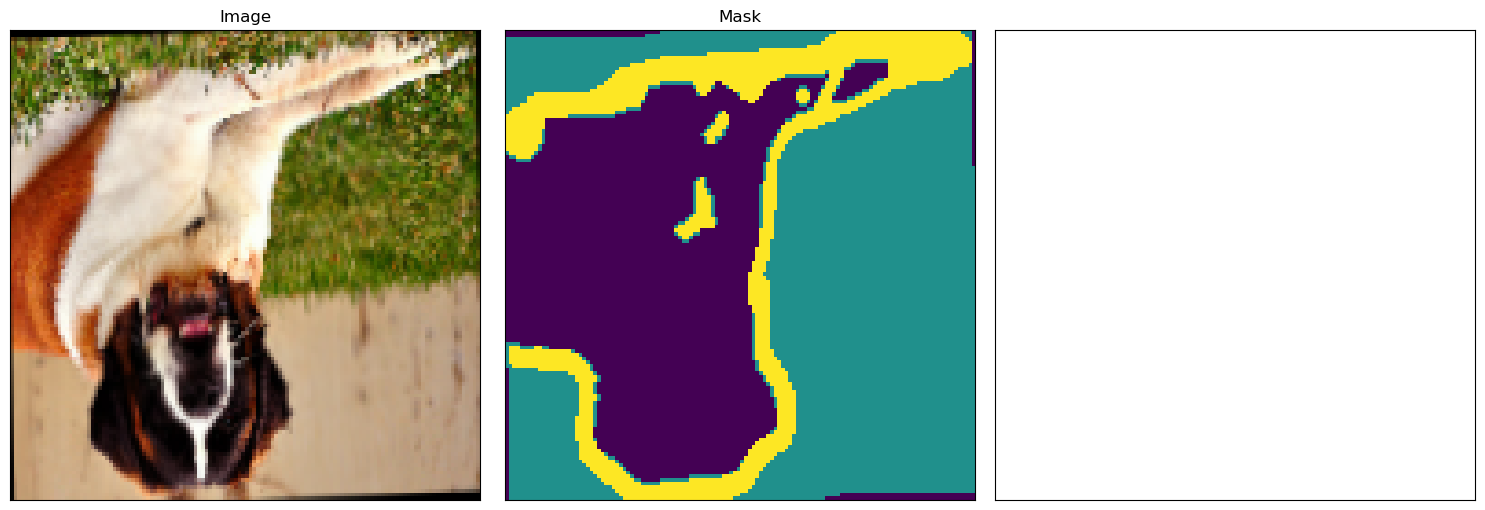

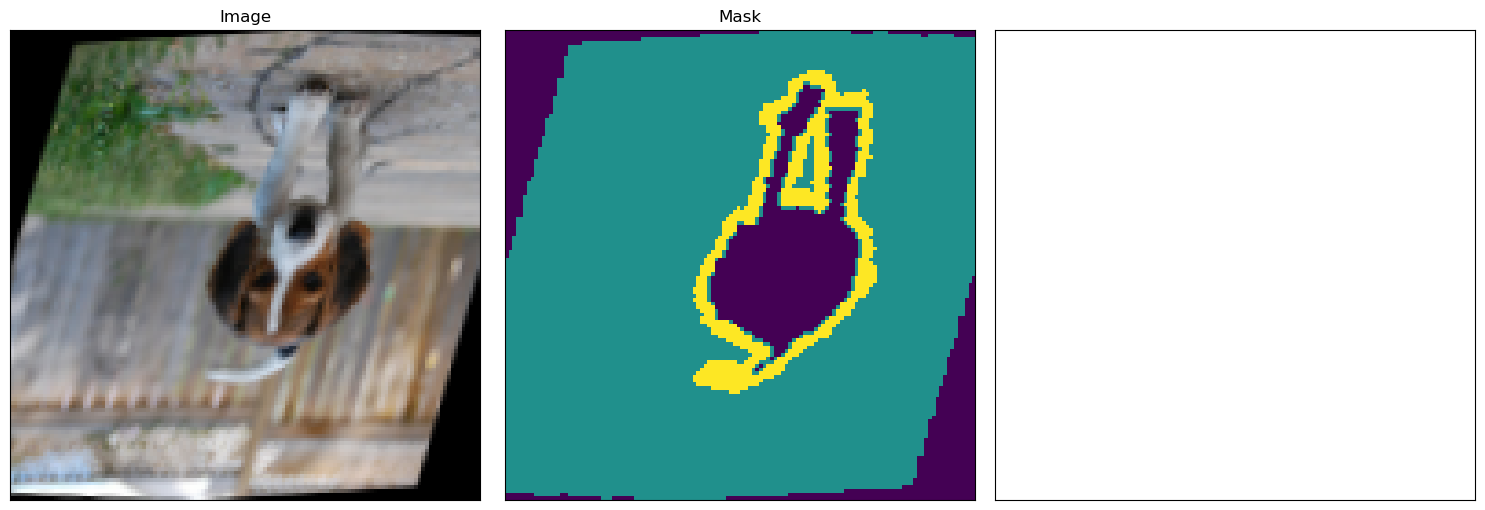

In [6]:
class Augmenter(sk.TreeClass):
    def __init__(
        self,
        vflip_rate: float,
        hflip_rate: float,
        rotate_range: tuple[int, int],
        vshear_range: tuple[int, int],
        hshear_range: tuple[int, int],
    ):
        self.vflip = sk.image.RandomVerticalFlip2D(rate=vflip_rate)
        self.hflip = sk.image.RandomHorizontalFlip2D(rate=hflip_rate)
        self.rotate = sk.image.RandomRotate2D(range=rotate_range)
        self.vshear = sk.image.RandomVerticalShear2D(range=vshear_range)
        self.hshear = sk.image.RandomHorizontalShear2D(range=hshear_range)

    def __call__(
        self,
        image: CHWArray,
        mask: CHWArray,
        *,
        key: jax.Array,
    ) -> tuple[CHWArray, CHWArray]:
        # same key for image and mask to ensure same augmentation
        k1, k2, k3, k4, k5 = jr.split(key, 5)
        # image augmentation
        image = self.vflip(image, key=k1)
        image = self.hflip(image, key=k2)
        image = self.rotate(image, key=k3)
        image = self.vshear(image, key=k4)
        image = self.hshear(image, key=k5)

        # mask augmentation
        mask = self.vflip(mask, key=k1)
        mask = self.hflip(mask, key=k2)
        mask = self.rotate(mask, key=k3)
        mask = self.vshear(mask, key=k4)
        mask = self.hshear(mask, key=k5)

        return image, mask


augmenter = Augmenter(
    vflip_rate=config.augmentation.vflip_rate,
    hflip_rate=config.augmentation.hflip_rate,
    rotate_range=config.augmentation.rotate_range,
    vshear_range=config.augmentation.vshear_range,
    hshear_range=config.augmentation.hshear_range,
)


@jax.jit
def augment(
    image: CHWArray,
    mask: CHWArray,
    key: jax.Array,
) -> tuple[CHWArray, CHWArray]:
    return augmenter(image, mask, key=key)


# check 5 augmented samples
for (image, mask), key in zip(test_ds, jr.split(jr.key(0), 5)):
    image, mask = augment(image, mask, key)
    plot_sample(image, mask)

## Model

Define `Unet` model


In [7]:
class Block(sk.TreeClass):
    def __init__(self, in_features: int, out_features: int, *, key: jax.Array):
        k1, k2 = jr.split(key, 2)
        self.conv1 = sk.nn.Conv2D(
            in_features=in_features,
            out_features=out_features,
            kernel_size=3,
            padding=1,
            bias_init=None,
            key=k1,
        )
        self.conv2 = sk.nn.Conv2D(
            in_features=out_features,
            out_features=out_features,
            kernel_size=3,
            padding=1,
            bias_init=None,
            key=k2,
        )

    def __call__(self, input: jax.Array) -> jax.Array:
        x = jax.nn.relu(self.conv1(input))
        x = jax.nn.relu(self.conv2(x))
        return x


class UpConv(sk.TreeClass):
    def __init__(self, in_features: int, out_features: int, *, key: jax.Array):
        self.conv = sk.nn.Conv2DTranspose(
            in_features=in_features,
            out_features=out_features,
            kernel_size=2,
            strides=2,
            bias_init=None,
            key=key,
        )

    def __call__(self, input: jax.Array) -> jax.Array:
        return self.conv(input)


class UNet(sk.TreeClass):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        features: int,
        *,
        key: jax.Array,
    ):
        kenc, kbottle, kdec, kother = jr.split(key, 4)

        k1, k2, k3, k4 = jr.split(kenc, 4)
        self.enc1 = Block(in_features, features, key=k1)
        self.enc2 = Block(features, features * 2, key=k2)
        self.enc3 = Block(features * 2, features * 4, key=k3)
        self.enc4 = Block(features * 4, features * 8, key=k4)

        self.bottleneck = Block(features * 8, features * 16, key=kbottle)

        k1, k2, k3, k4, k5, k6, k7, k8 = jr.split(kdec, 8)
        self.upconv4 = UpConv(features * 16, features * 8, key=k1)
        self.dec4 = Block(features * 16, features * 8, key=k2)
        self.upconv3 = UpConv(features * 8, features * 4, key=k3)
        self.dec3 = Block(features * 8, features * 4, key=k4)
        self.upconv2 = UpConv(features * 4, features * 2, key=k5)
        self.dec2 = Block(features * 4, features * 2, key=k6)
        self.upconv1 = UpConv(features * 2, features, key=k7)
        self.dec1 = Block(features * 2, features, key=k8)

        self.pool = sk.nn.MaxPool2D(kernel_size=2, strides=2)
        self.final = sk.nn.Conv2D(features, out_features, 1, key=kother)

    def __call__(self, input: CHWArray) -> CHWArray:
        _, h, w = input.shape
        assert log2(h) % 1 == 0, f"{h=} must be a power of 2"
        assert log2(w) % 1 == 0, f"{w=} must be a power of 2"

        enc1 = self.enc1(input)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.upconv4(bottleneck)
        # concat along channel axis axis=0 not axis=1
        # recall that all models do not have batch dimension
        # and batch dimension can be added by `jax.vmap`
        dec4 = jnp.concatenate([dec4, enc4], axis=0)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = jnp.concatenate([dec3, enc3], axis=0)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = jnp.concatenate([dec2, enc2], axis=0)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = jnp.concatenate([dec1, enc1], axis=0)
        dec1 = self.dec1(dec1)
        return self.final(dec1)

## Train


In [8]:
net = sk.tree_mask(UNet(3, 3, 32, key=jr.key(0)))
optim = optax.adam(
    learning_rate=config.optim.lr,
    b1=config.optim.beta1,
    b2=config.optim.beta2,
)
optim_state = optim.init(net)

print(sk.tree_summary(net, depth=1))

┌───────────┬─────────┬─────────┬────────┐
│Name       │Type     │Count    │Size    │
├───────────┼─────────┼─────────┼────────┤
│.enc1      │Block    │10,080   │39.38KB │
├───────────┼─────────┼─────────┼────────┤
│.enc2      │Block    │55,296   │216.00KB│
├───────────┼─────────┼─────────┼────────┤
│.enc3      │Block    │221,184  │864.00KB│
├───────────┼─────────┼─────────┼────────┤
│.enc4      │Block    │884,736  │3.38MB  │
├───────────┼─────────┼─────────┼────────┤
│.bottleneck│Block    │3,538,944│13.50MB │
├───────────┼─────────┼─────────┼────────┤
│.upconv4   │UpConv   │524,288  │2.00MB  │
├───────────┼─────────┼─────────┼────────┤
│.dec4      │Block    │1,769,472│6.75MB  │
├───────────┼─────────┼─────────┼────────┤
│.upconv3   │UpConv   │131,072  │512.00KB│
├───────────┼─────────┼─────────┼────────┤
│.dec3      │Block    │442,368  │1.69MB  │
├───────────┼─────────┼─────────┼────────┤
│.upconv2   │UpConv   │32,768   │128.00KB│
├───────────┼─────────┼─────────┼────────┤
│.dec2     

  0%|          | 0/100 [00:00<?, ?it/s]

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extra

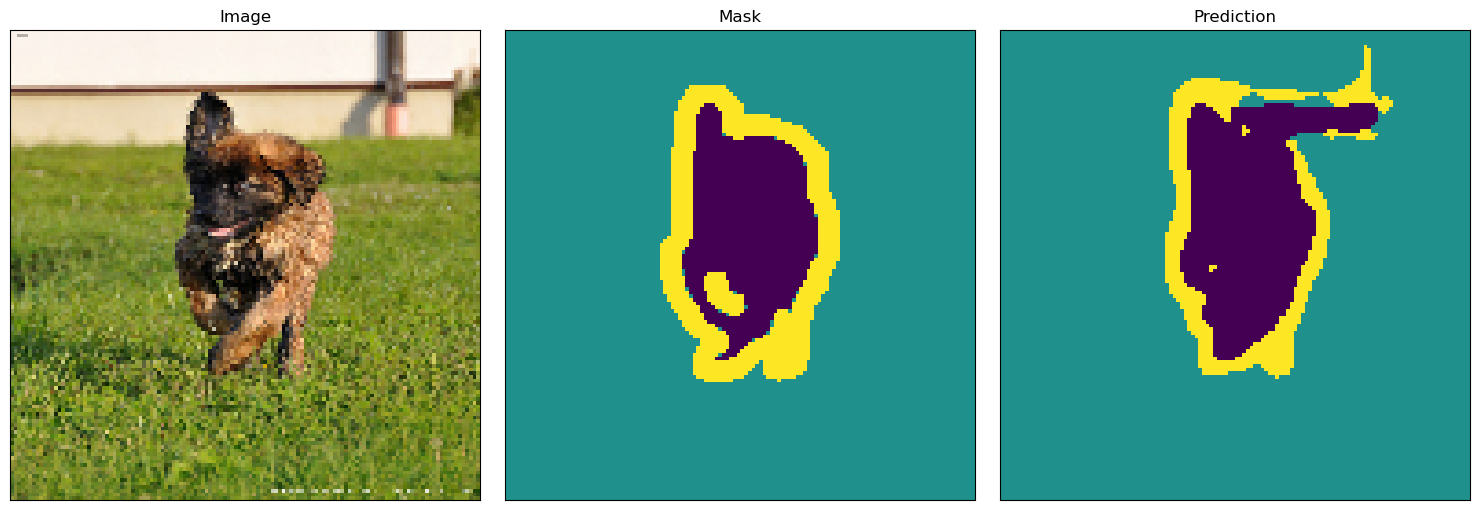

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extra

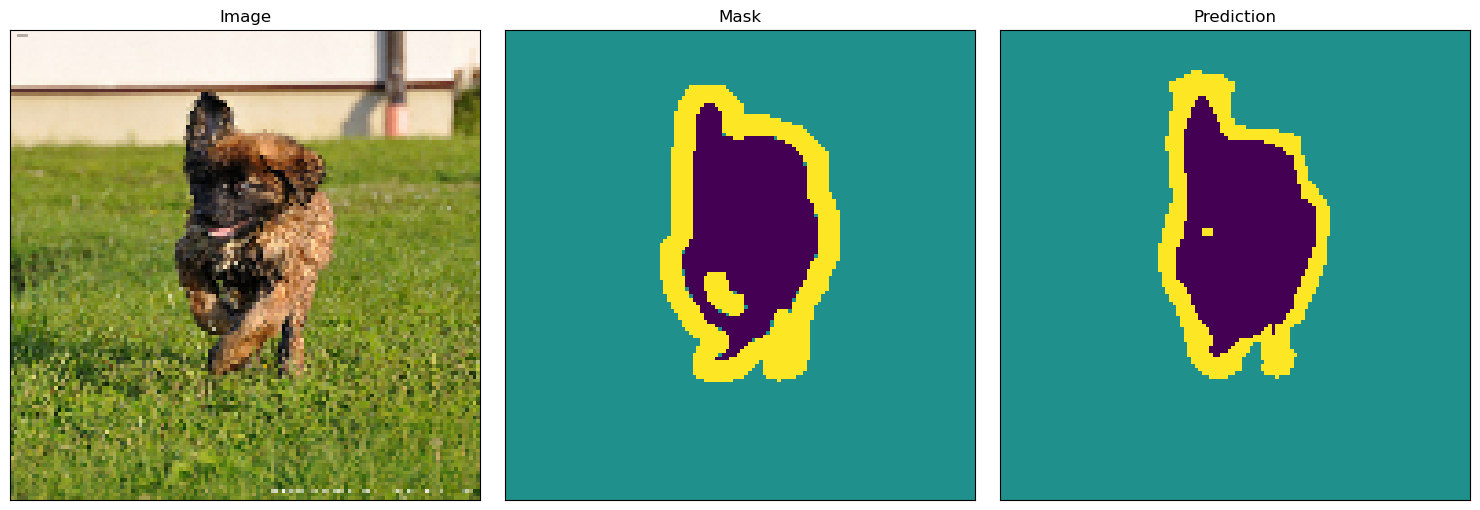

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extra

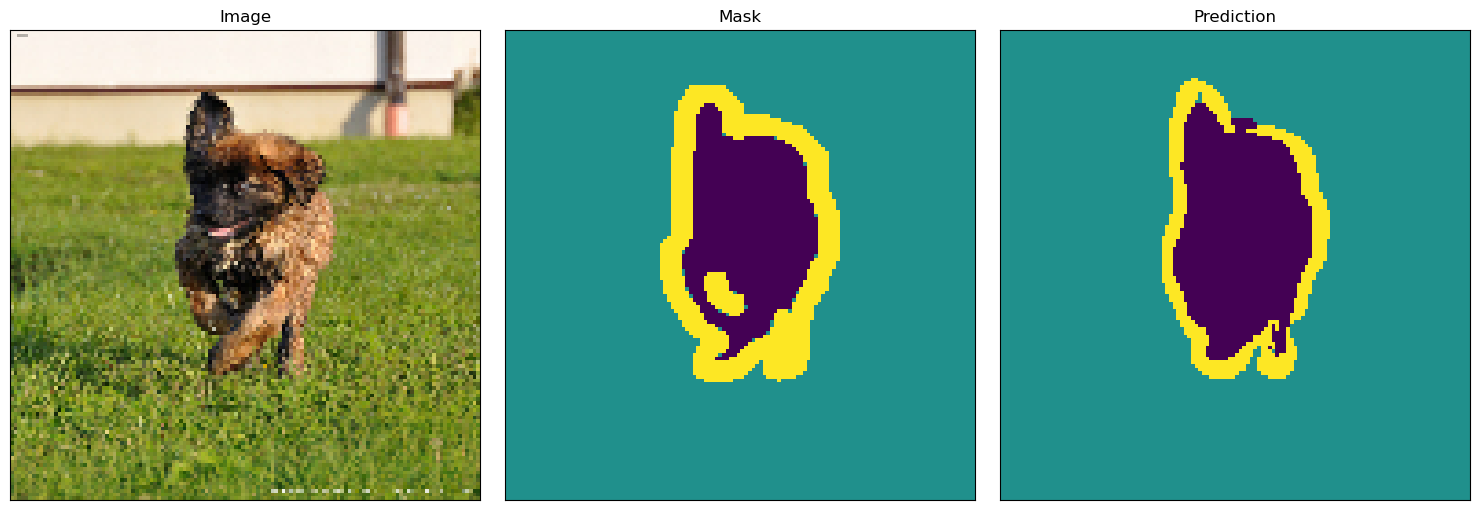

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extra

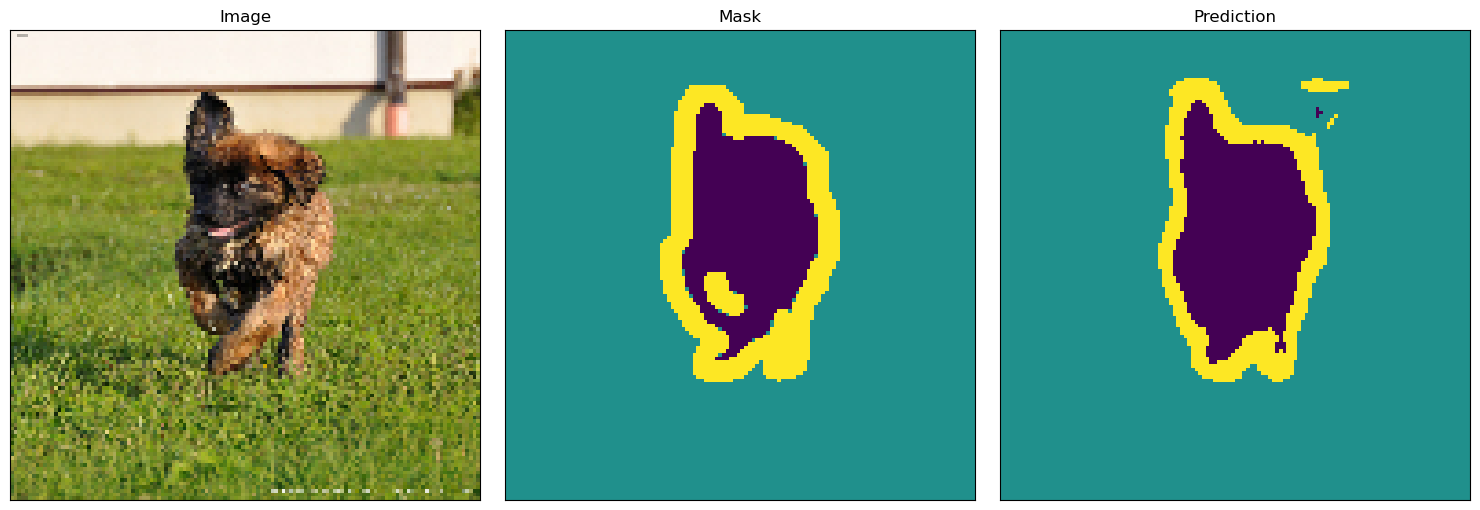

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extra

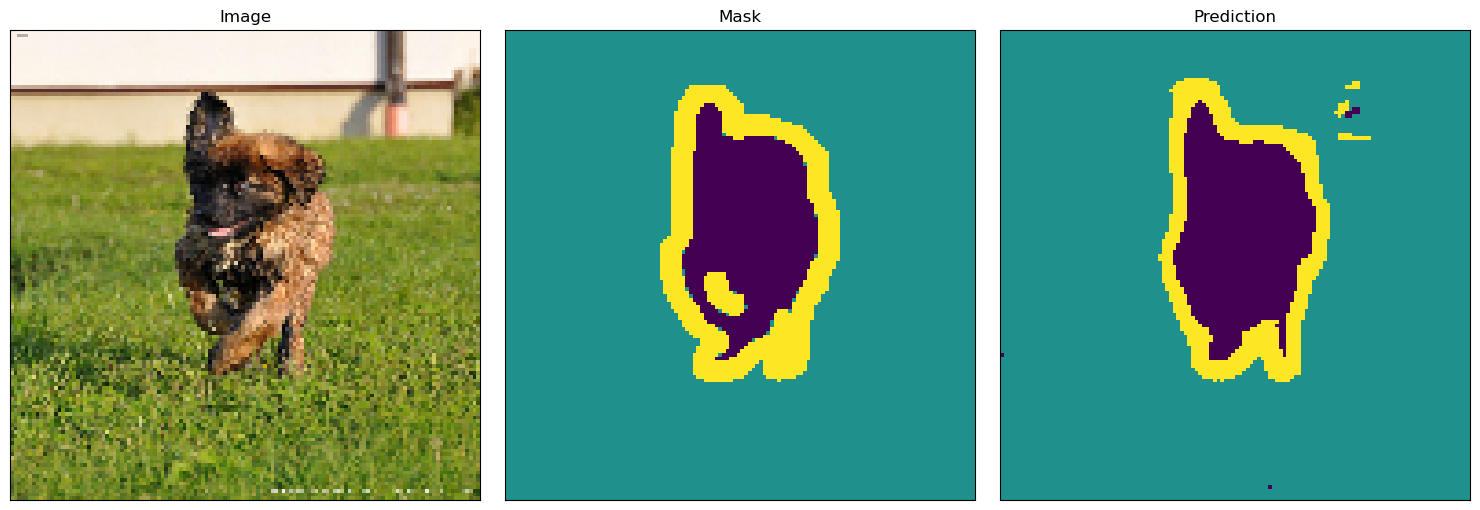

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extra

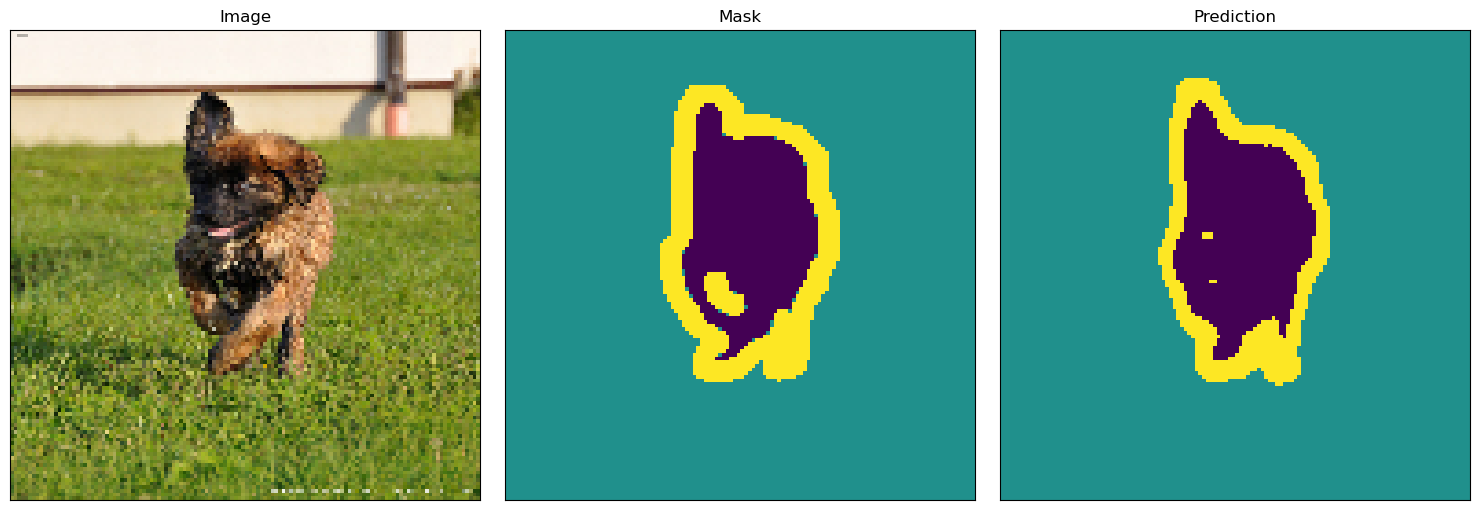

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extra

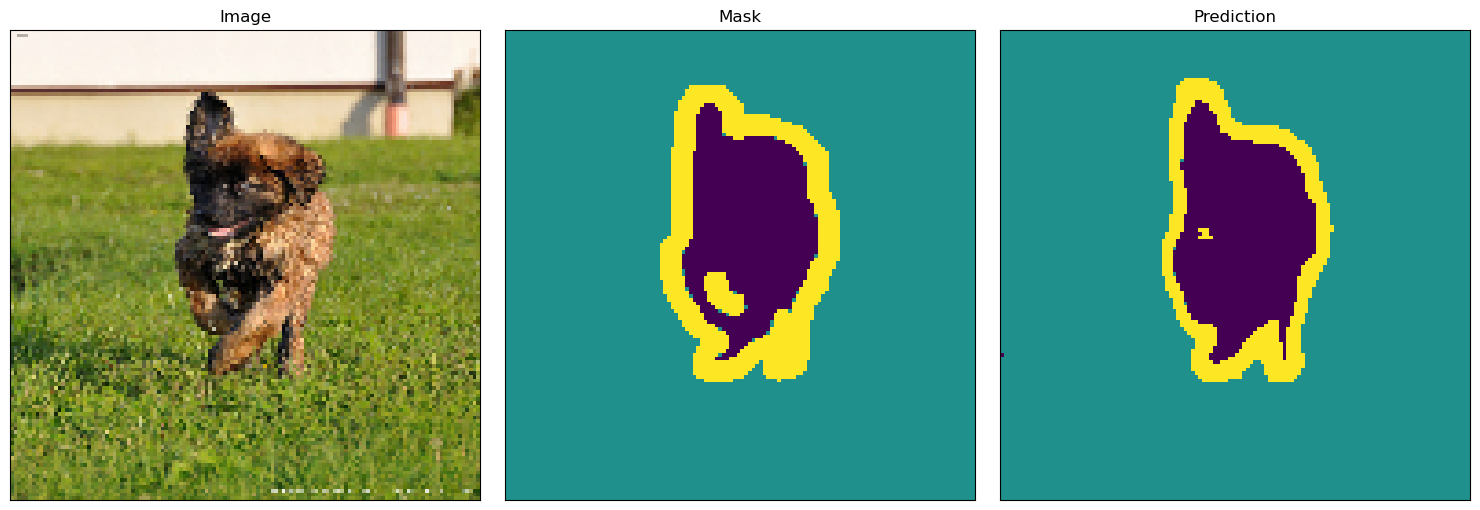

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extra

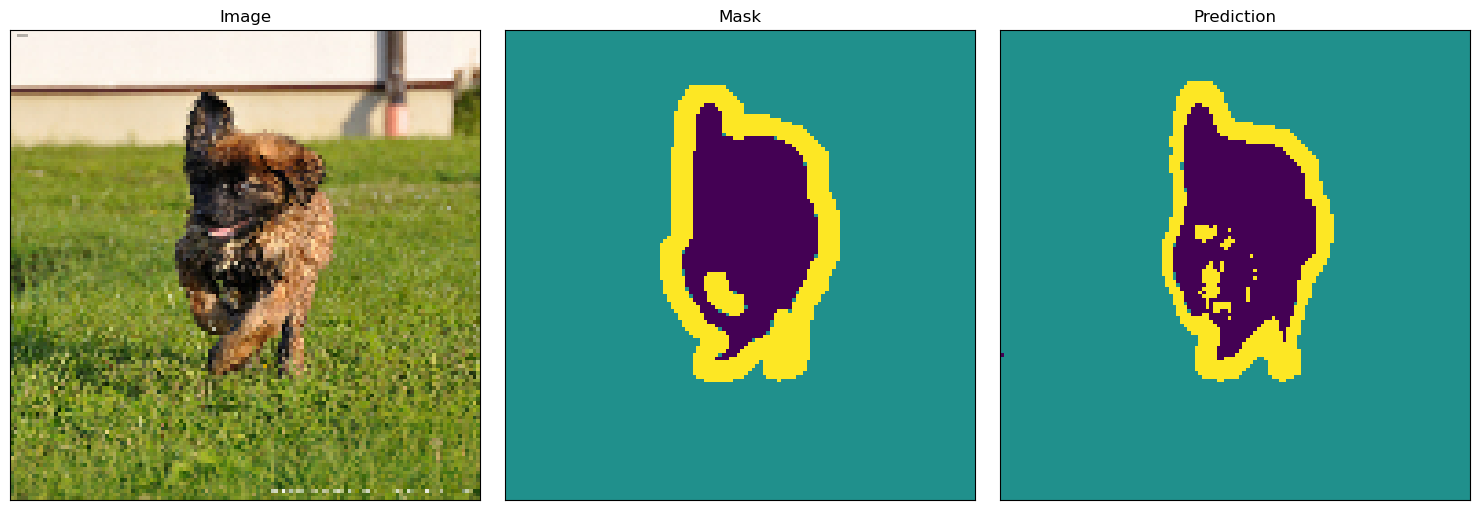

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extra

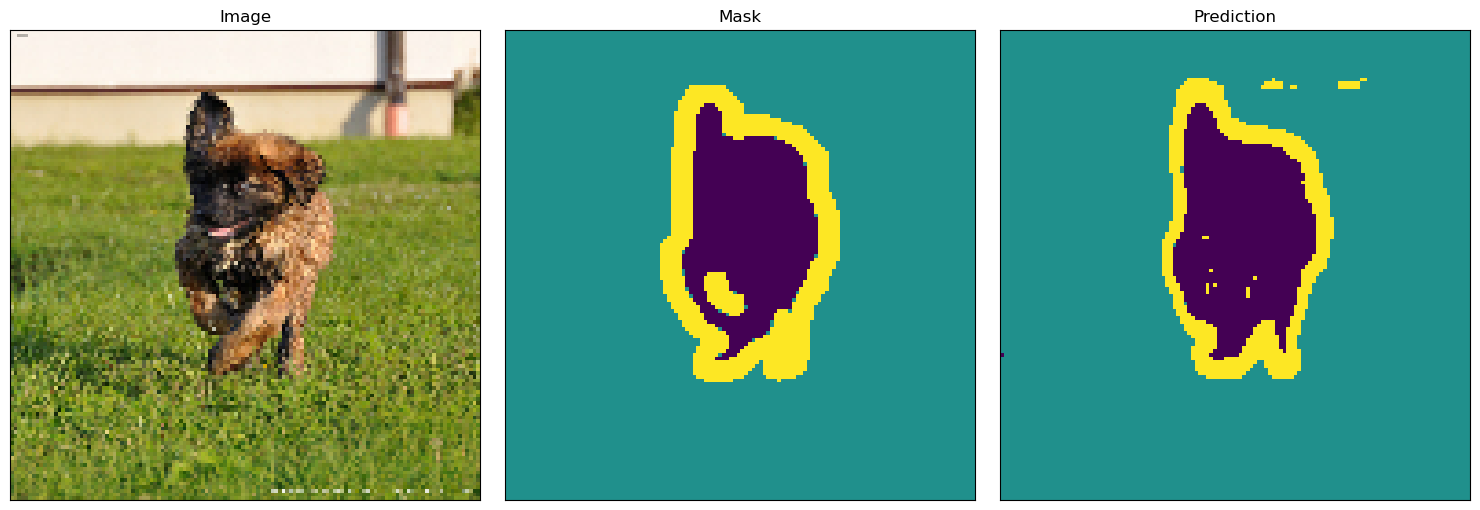

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extra

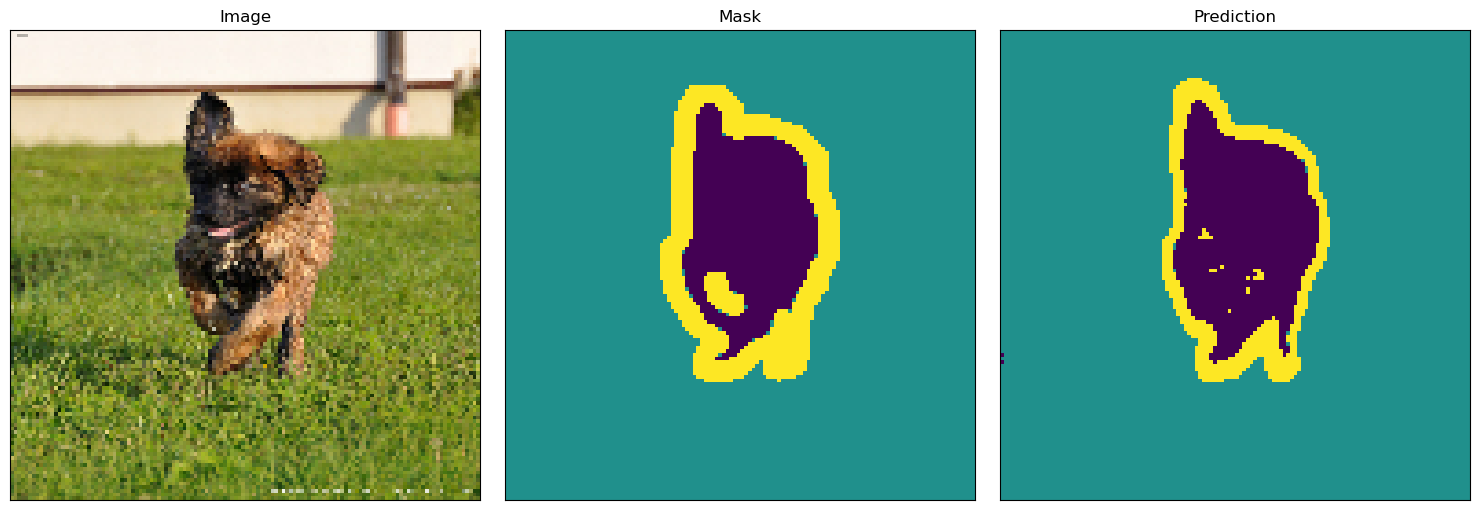

In [9]:
def accuracy(logits: CHWArray, mask: CHWArray) -> jax.Array:
    assert logits.ndim == mask.ndim == 3
    assert logits.shape[1:] == mask.shape[1:], f"{logits.shape[1:]=}!={mask.shape[1:]=}"
    return jnp.mean(jnp.argmax(logits, axis=0) == mask)


def softmax_cross_entropy(logits: CHWArray, mask: CHWArray) -> jax.Array:
    assert logits.ndim == mask.ndim == 3
    assert logits.shape[1:] == mask.shape[1:], f"{logits.shape[1:]=}!={mask.shape[1:]=}"
    num_classes, _, _ = logits.shape
    logits = logits.transpose(1, 2, 0).reshape(-1, num_classes)  # (H*W, C)
    onehot = mask.transpose(1, 2, 0).reshape(-1)  # (H*W)
    onehot = jax.nn.one_hot(onehot, num_classes)  # (H*W, C)
    return -jnp.sum(onehot * jax.nn.log_softmax(logits, axis=1), axis=1)


def loss_func(net: UNet, input: Batched[CHWArray], target: Batched[CHWArray]):
    net: UNet = sk.tree_unmask(net)
    logits: Batched[CHWArray] = jax.vmap(net)(input)
    loss = jnp.mean(jax.vmap(softmax_cross_entropy)(logits, target))
    metric = jnp.mean(jax.vmap(accuracy)(logits, target))
    return loss, (loss, metric)


@jax.jit
def train_step(
    net: UNet,
    optim_state: optax.OptState,
    input: Batched[CHWArray],
    target: Batched[CHWArray],
):
    grads, (loss, accuracy) = jax.grad(loss_func, has_aux=True)(net, input, target)
    updates, optim_state = optim.update(grads, optim_state)
    net = optax.apply_updates(net, updates)
    return net, optim_state, (loss, accuracy)


key = jr.key(config.train.seed)

sample_image, sample_mask = next(iter(test_ds))
epoch_loss = jnp.inf
epoch_accuracy = 0.0
net = sk.tree_mask(net)  # mask the tree to pass through `jax` transformations

for epoch in (pbar := tqdm(range(1, config.train.epochs + 1))):
    key, subkey = jr.split(key)
    epoch_loss_history = []
    epoch_accuracy_history = []

    string = f"[loss/acc] epoch:{epoch_loss:.4e}/{epoch_accuracy:.4f}\t"

    for images, masks in train_ds:
        # augment images and masks
        images, masks = jax.vmap(augment)(images, masks, jr.split(subkey, len(images)))
        net, optim_state, (loss, accuracy) = train_step(net, optim_state, images, masks)
        epoch_loss_history.append(loss)
        epoch_accuracy_history.append(accuracy)
        pbar.set_description(string + f"|batch:{loss:.4e}/{accuracy:.4f}")

    epoch_loss = jnp.mean(jnp.stack(epoch_loss_history))
    epoch_accuracy = jnp.mean(jnp.stack(epoch_accuracy_history))

    if epoch % config.train.plot_every == 0:
        pred_mask = sk.tree_unmask(net)(sample_image)
        plot_sample(sample_image, sample_mask, pred_mask)

net = sk.tree_unmask(net)  # finish training

## Visualize results


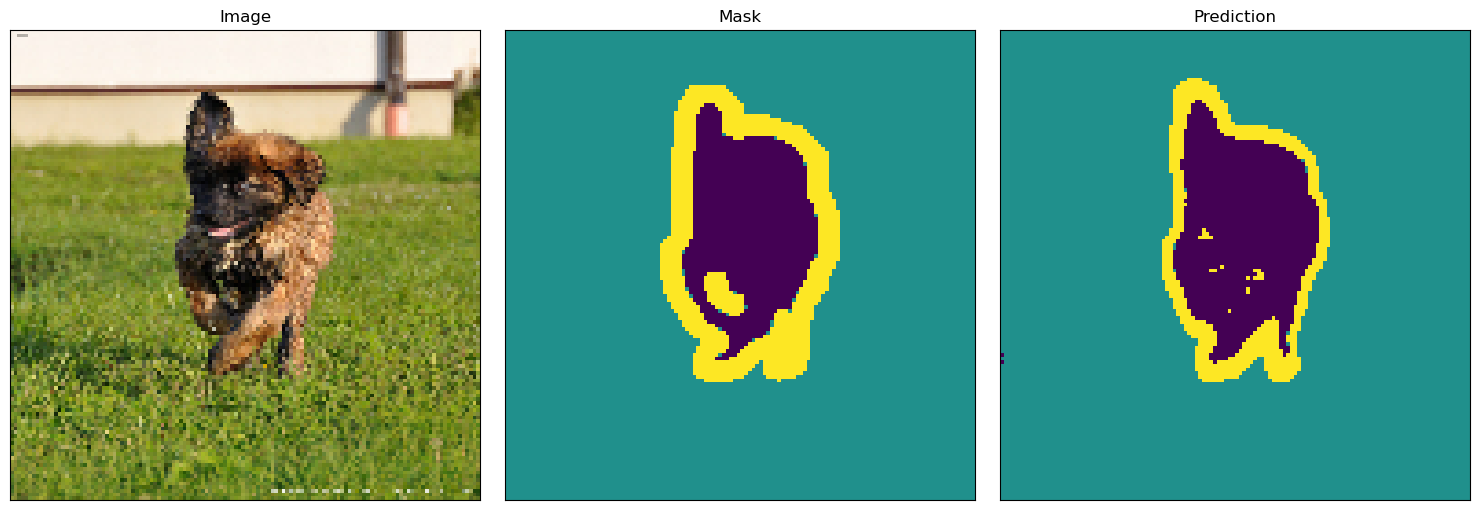

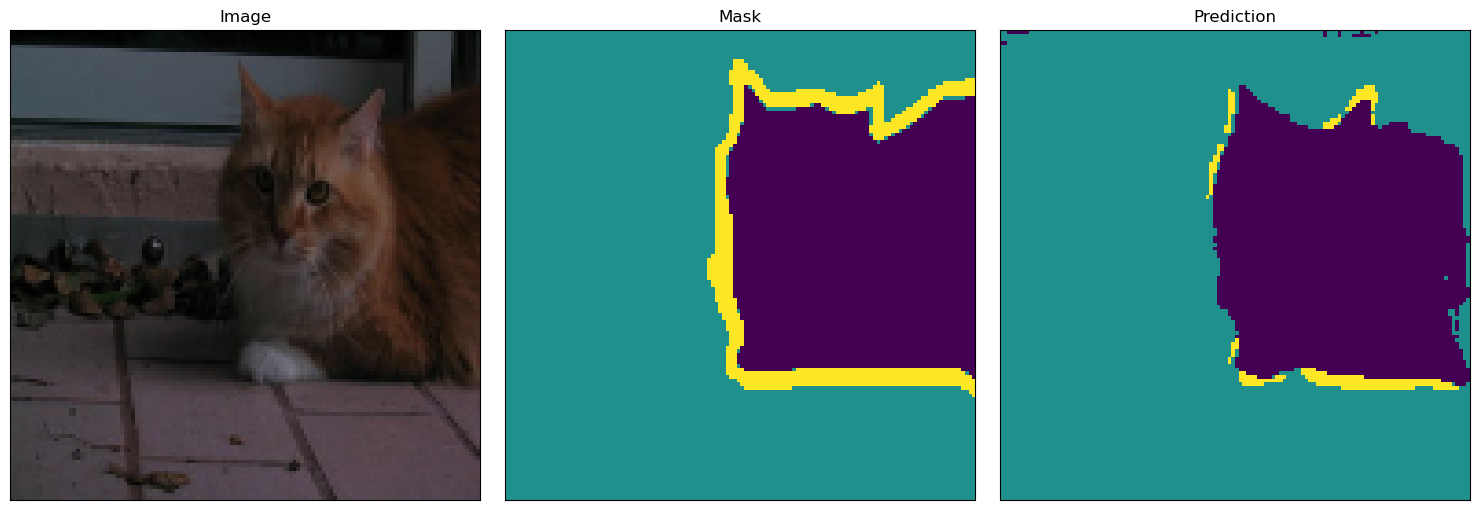

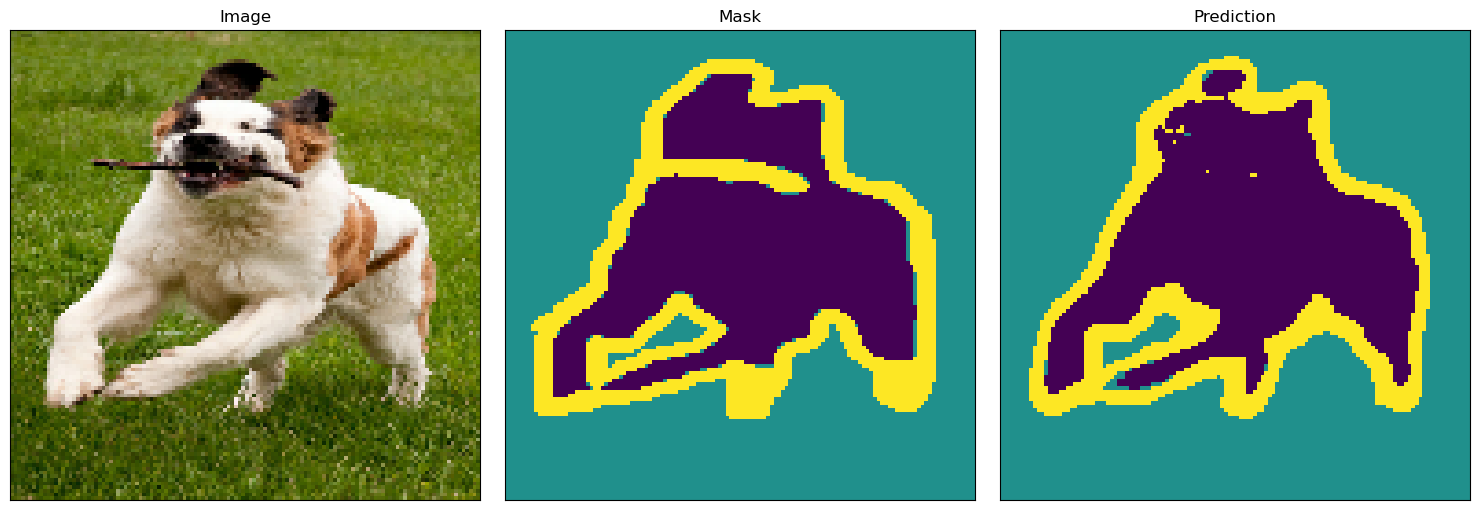

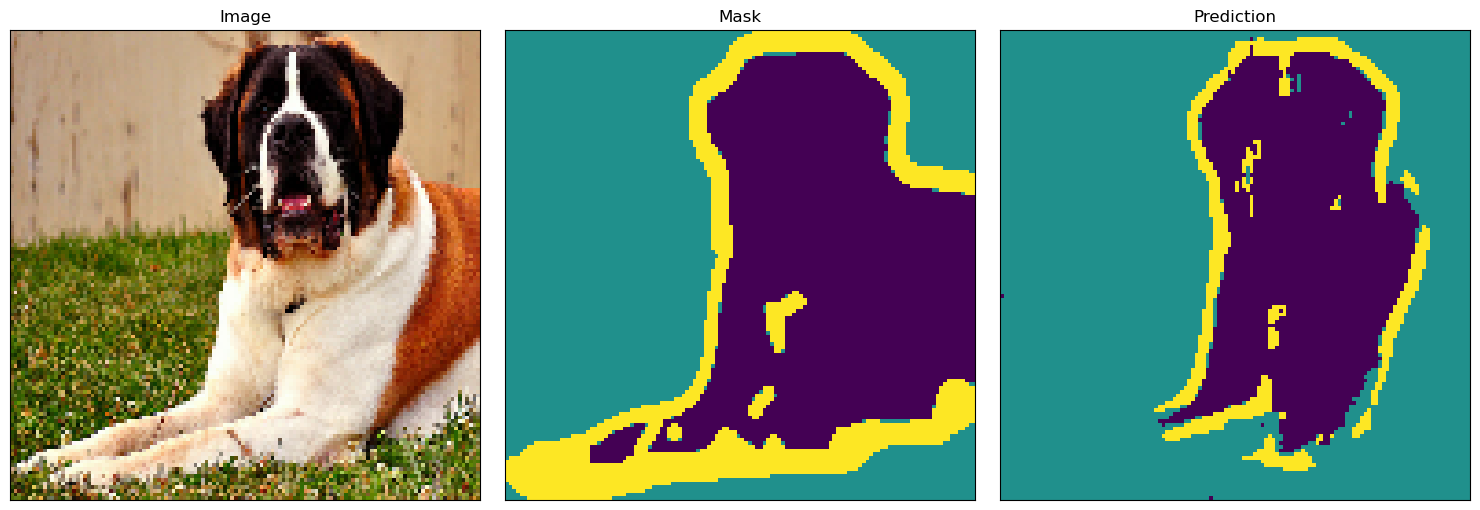

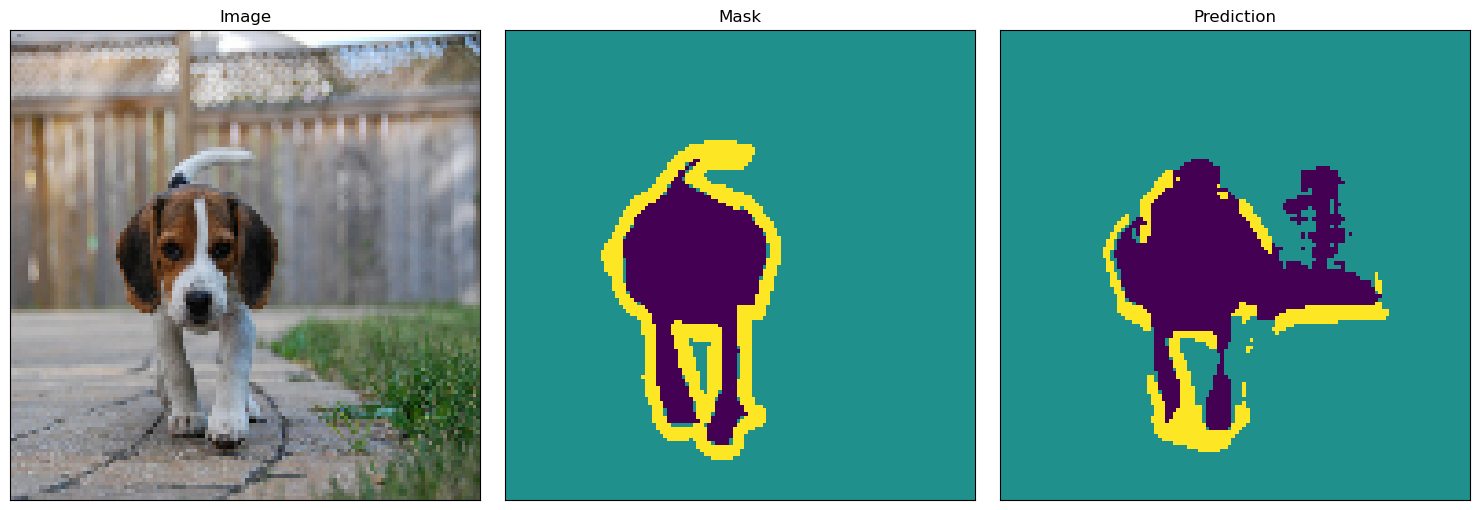

In [10]:
for _, (image, mask) in zip(range(5), test_ds):
    pred_mask = net(image)
    plot_sample(image, mask, pred_mask)